In [1]:
import sys
import pathlib
import datetime
import xarray as xr
import dask
from cluster import PerlmutterSLURMCluster
from process_files import (
    glob_nc_files,
    process_cases,
    memory,
    open_compress_and_save_file,
    set_coords,
    add_additional_coords,
    expand_ensemble_dims,
    set_encoding,
    save_to_netcdf,
    get_case_metadata,
)
from data_config import (
    get_scratch_dir,
    get_dask_log_dir,
    get_dask_local_dir,
    get_compressed_data_dir,
    get_data_archive_dir,
)

In [2]:
scratch = get_scratch_dir()
dask_log_directory = get_dask_log_dir()
dask_local_directory = get_dask_local_dir()

In [3]:
n_workers = 1  # Number of Slurm jobs to launch in parallel
n_nodes_per_calc = 1  # Number of nodes to reserve for each Slurm job
n_cores_per_node = 48  # Number of CPU cores per node
mem_per_node = "512 GB"  # Total memory per node
cluster_kwargs = {
    # Dask worker options
    "processes": n_cores_per_node,
    "cores": n_cores_per_node,  # total number of cores (per Slurm job) for Dask worker
    "memory": mem_per_node,  # total memory (per Slurm job) for Dask worker
    # SLURM options
    "job_name": "dor-dataset-compression",
    "shebang": "#!/bin/bash",
    "walltime": "00:30:00",  # DD:HH:SS
    "job_mem": "0",  # all memory on node
    "job_script_prologue": [
        "source ~/.bashrc"
    ],  # commands to run before calculation, including exports
    "job_directives_skip": ["-n", "--cpus-per-task"],  # Slurm directives we can skip
    "job_extra_directives": [
        f"-N {n_nodes_per_calc}",
        "-q debug",
        "-C cpu",
    ],  # num. of nodes for calc (-N), queue (-q), and constraints (-c)
    "log_directory": str(dask_log_directory),
    "local_directory": str(dask_local_directory),
    "worker_extra_args": ["--lifetime", "25m", "--lifetime-stagger", "4m"],
}

cluster = PerlmutterSLURMCluster(**cluster_kwargs)

client = dask.distributed.client.Client(cluster)
cluster

Dashboard: https://jupyter.nersc.gov/user/abanihi/perlmutter-login-node-base/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.55.64.16:41623,Workers: 0
Dashboard: https://jupyter.nersc.gov/user/abanihi/perlmutter-login-node-base/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


Task exception was never retrieved
future: <Task finished name='Task-2848' coro=<Client._gather.<locals>.wait() done, defined at /global/homes/a/abanihi/.conda/envs/dor/lib/python3.12/site-packages/distributed/client.py:2394> exception=AllExit()>
Traceback (most recent call last):
  File "/global/homes/a/abanihi/.conda/envs/dor/lib/python3.12/site-packages/distributed/client.py", line 2403, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-2788' coro=<Client._gather.<locals>.wait() done, defined at /global/homes/a/abanihi/.conda/envs/dor/lib/python3.12/site-packages/distributed/client.py:2394> exception=AllExit()>
Traceback (most recent call last):
  File "/global/homes/a/abanihi/.conda/envs/dor/lib/python3.12/site-packages/distributed/client.py", line 2403, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-2865' coro=<Client._gather.<local

In [4]:
# cluster.scale(20*n_cores_per_node)
cluster.adapt(minimum_jobs=2, maximum_jobs=3)

In [5]:
# print(cluster.job_script())

In [6]:
# cluster.scale(0)

In [7]:
parent_dir = pathlib.Path.cwd().parent
sys.path.append(str(parent_dir))

In [8]:
import atlas

In [9]:
@memory.cache
def get_done_cases_df(today=datetime.datetime.today().date()):
    calc = atlas.global_irf_map(cdr_forcing="DOR", vintage="001")

    data = calc.df_case_status
    done = data.loc[data.archive]

    done_cases = done.index.to_list()
    done_cases.remove("smyle.cdr-atlas-v0.control.001")
    done_cases = sorted(done_cases)

    df = calc.df.loc[done_cases]
    return df, done_cases

In [10]:
%%time

df, done_cases = get_done_cases_df()
df

CPU times: user 2.36 ms, sys: 3 ms, total: 5.35 ms
Wall time: 6.24 ms


,blueprint,polygon,polygon_master,basin,start_date,cdr_forcing,cdr_forcing_file,simulation_key,refdate,stop_n,wallclock,curtail_output
case,,,,,,,,,,,,
smyle.cdr-atlas-v0.glb-dor_North_Atlantic_basin_000_1999-01-01_00000.001,smyle,0.0,0.0,North_Atlantic_basin,1999-01,DOR,/global/cfs/projectdirs/m4746/Projects/OAE-Eff...,glb-dor_North_Atlantic_basin_000_1999-01-01_00000,0347-01-01,15,10:00:00,True
smyle.cdr-atlas-v0.glb-dor_North_Atlantic_basin_000_1999-04-01_00001.001,smyle,0.0,0.0,North_Atlantic_basin,1999-04,DOR,/global/cfs/projectdirs/m4746/Projects/OAE-Eff...,glb-dor_North_Atlantic_basin_000_1999-04-01_00001,0347-04-01,15,10:00:00,True
smyle.cdr-atlas-v0.glb-dor_North_Atlantic_basin_000_1999-07-01_00002.001,smyle,0.0,0.0,North_Atlantic_basin,1999-07,DOR,/global/cfs/projectdirs/m4746/Projects/OAE-Eff...,glb-dor_North_Atlantic_basin_000_1999-07-01_00002,0347-07-01,15,10:00:00,True
smyle.cdr-atlas-v0.glb-dor_North_Atlantic_basin_000_1999-10-01_00003.001,smyle,0.0,0.0,North_Atlantic_basin,1999-10,DOR,/global/cfs/projectdirs/m4746/Projects/OAE-Eff...,glb-dor_North_Atlantic_basin_000_1999-10-01_00003,0347-10-01,15,10:00:00,True
smyle.cdr-atlas-v0.glb-dor_North_Atlantic_basin_001_1999-01-01_00004.001,smyle,1.0,1.0,North_Atlantic_basin,1999-01,DOR,/global/cfs/projectdirs/m4746/Projects/OAE-Eff...,glb-dor_North_Atlantic_basin_001_1999-01-01_00004,0347-01-01,15,10:00:00,True
...,...,...,...,...,...,...,...,...,...,...,...,...
smyle.cdr-atlas-v0.glb-dor_North_Pacific_basin_041_1999-07-01_00766.001,smyle,41.0,191.0,North_Pacific_basin,1999-07,DOR,/global/cfs/projectdirs/m4746/Projects/OAE-Eff...,glb-dor_North_Pacific_basin_041_1999-07-01_00766,0347-07-01,15,10:00:00,True
smyle.cdr-atlas-v0.glb-dor_North_Pacific_basin_041_1999-10-01_00767.001,smyle,41.0,191.0,North_Pacific_basin,1999-10,DOR,/global/cfs/projectdirs/m4746/Projects/OAE-Eff...,glb-dor_North_Pacific_basin_041_1999-10-01_00767,0347-10-01,15,10:00:00,True
smyle.cdr-atlas-v0.glb-dor_North_Pacific_basin_042_1999-01-01_00768.001,smyle,42.0,192.0,North_Pacific_basin,1999-01,DOR,/global/cfs/projectdirs/m4746/Projects/OAE-Eff...,glb-dor_North_Pacific_basin_042_1999-01-01_00768,0347-01-01,15,10:00:00,True


In [11]:
base_directory = get_data_archive_dir()

In [12]:
case = done_cases[0]
nc_files = glob_nc_files(base_path=base_directory, case=case)
len(nc_files)

Globbing files (this may take a while)...


180

## Add coordinate information and expand dimensions

In [13]:
path = nc_files[146]
path

PosixPath('/global/cfs/projectdirs/m4746/Projects/Ocean-CDR-Atlas-v0/data/archive/smyle.cdr-atlas-v0.glb-dor_North_Atlantic_basin_000_1999-01-01_00000.001/ocn/hist/smyle.cdr-atlas-v0.glb-dor_North_Atlantic_basin_000_1999-01-01_00000.001.pop.h.0359-03.nc')

In [14]:
case_metadata = get_case_metadata(case, df=df)

expanded = (
    xr.open_dataset(path, engine="netcdf4")
    .pipe(set_coords)
    .pipe(add_additional_coords, case, case_metadata)
    .pipe(expand_ensemble_dims)
)
expanded

/tmp/ipykernel_1296439/920848842.py:4: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  xr.open_dataset(path, engine="netcdf4")


<xarray.Dataset> Size: 478MB
Dimensions:                     (injection_date: 1, elapsed_time: 1, d2: 2,
                                 z_t: 60, z_t_150m: 15, z_w: 60, z_w_top: 60,
                                 z_w_bot: 60, nlat: 384, nlon: 320,
                                 polygon_id: 1)
Coordinates: (12/64)
    time_bound                  (injection_date, elapsed_time, d2) object 16B ...
    time                        (injection_date, elapsed_time) object 8B 0359...
  * z_t                         (z_t) float32 240B 500.0 1.5e+03 ... 5.375e+05
  * z_t_150m                    (z_t_150m) float32 60B 500.0 ... 1.45e+04
  * z_w                         (z_w) float32 240B 0.0 1e+03 ... 5e+05 5.25e+05
  * z_w_top                     (z_w_top) float32 240B 0.0 1e+03 ... 5.25e+05
    ...                          ...
    sflux_factor                float64 8B ...
    nsurface_t                  float64 8B ...
    nsurface_u                  float64 8B ...
  * elapsed_time                (elapsed_time) timedelta64[ns] 8B 4439 days
  * polygon_id                  (polygon_id) int64 8B 0
  * injection_date              (injection_date) object 8B 1999-01-01 00:00:00
Dimensions without coordinates: d2, nlat, nlon
Data variables: (12/46)
    CO3                         (polygon_id, injection_date, elapsed_time, z_t, nlat, nlon) float32 29MB ...
    HCO3                        (polygon_id, injection_date, elapsed_time, z_t, nlat, nlon) float32 29MB ...
    H2CO3                       (polygon_id, injection_date, elapsed_time, z_t, nlat, nlon) float32 29MB ...
    pH_3D                       (polygon_id, injection_date, elapsed_time, z_t, nlat, nlon) float32 29MB ...
    CO3_ALT_CO2                 (polygon_id, injection_date, elapsed_time, z_t, nlat, nlon) float32 29MB ...
    pH_3D_ALT_CO2               (polygon_id, injection_date, elapsed_time, z_t, nlat, nlon) float32 29MB ...
    ...                          ...
    STF_ALK_ALT_CO2             (polygon_id, injection_date, elapsed_time, nlat, nlon) float32 492kB ...
    IAGE                        (polygon_id, injection_date, elapsed_time, z_t, nlat, nlon) float32 29MB ...
    tend_zint_100m_DIC          (polygon_id, injection_date, elapsed_time, nlat, nlon) float32 492kB ...
    tend_zint_100m_DIC_ALT_CO2  (polygon_id, injection_date, elapsed_time, nlat, nlon) float32 492kB ...
    tend_zint_100m_ALK          (polygon_id, injection_date, elapsed_time, nlat, nlon) float32 492kB ...
    tend_zint_100m_ALK_ALT_CO2  (polygon_id, injection_date, elapsed_time, nlat, nlon) float32 492kB ...
Attributes:
    title:             smyle.cdr-atlas-v0.glb-dor_North_Atlantic_basin_000_19...
    history:           none
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    time_period_freq:  month_1
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    contents:          Diagnostic and Prognostic Variables
    source:            CCSM POP2, the CCSM Ocean Component
    revision:          $Id$
    calendar:          All years have exactly  365 days.
    start_time:        This dataset was created on 2024-11-05 at 02:05:21.8
    cell_methods:      cell_methods = time: mean ==> the variable values are ...

## Compute anomalies

In [15]:
# anomalies = compute_anomalies(expanded)
# anomalies

## Quick check for polygon's correctness

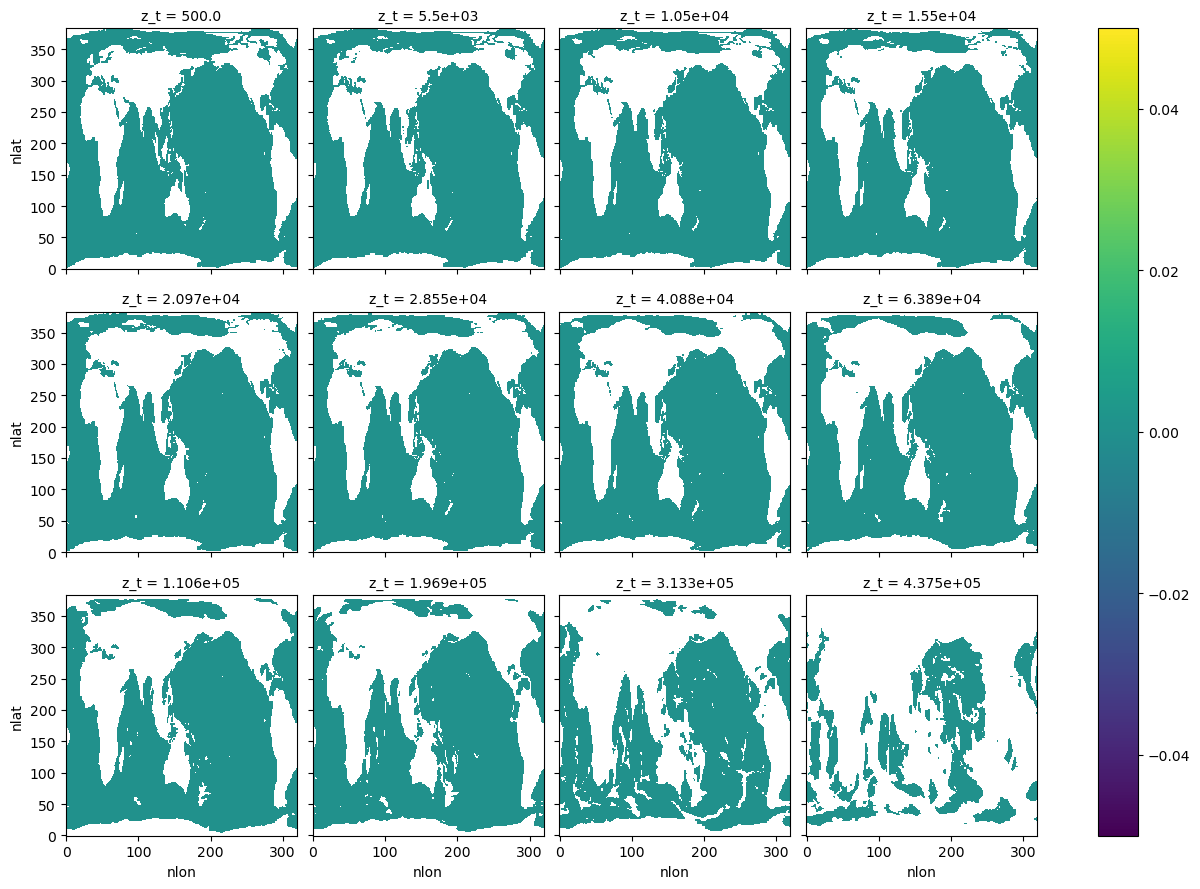

In [16]:
(expanded["ALK"] - expanded["ALK_ALT_CO2"]).isel(z_t=range(0, 60, 5)).plot(
    col_wrap=4, col="z_t", robust=True
);

## Fix encoding

In [17]:
encoded = expanded.pipe(set_encoding)
encoded

<xarray.Dataset> Size: 478MB
Dimensions:                     (injection_date: 1, elapsed_time: 1, d2: 2,
                                 z_t: 60, z_t_150m: 15, z_w: 60, z_w_top: 60,
                                 z_w_bot: 60, nlat: 384, nlon: 320,
                                 polygon_id: 1)
Coordinates: (12/64)
    time_bound                  (injection_date, elapsed_time, d2) object 16B ...
    time                        (injection_date, elapsed_time) object 8B 0359...
  * z_t                         (z_t) float32 240B 500.0 1.5e+03 ... 5.375e+05
  * z_t_150m                    (z_t_150m) float32 60B 500.0 ... 1.45e+04
  * z_w                         (z_w) float32 240B 0.0 1e+03 ... 5e+05 5.25e+05
  * z_w_top                     (z_w_top) float32 240B 0.0 1e+03 ... 5.25e+05
    ...                          ...
    sflux_factor                float64 8B ...
    nsurface_t                  float64 8B ...
    nsurface_u                  float64 8B ...
  * elapsed_time                (elapsed_time) timedelta64[ns] 8B 4439 days
  * polygon_id                  (polygon_id) int64 8B 0
  * injection_date              (injection_date) object 8B 1999-01-01 00:00:00
Dimensions without coordinates: d2, nlat, nlon
Data variables: (12/46)
    CO3                         (polygon_id, injection_date, elapsed_time, z_t, nlat, nlon) float32 29MB ...
    HCO3                        (polygon_id, injection_date, elapsed_time, z_t, nlat, nlon) float32 29MB ...
    H2CO3                       (polygon_id, injection_date, elapsed_time, z_t, nlat, nlon) float32 29MB ...
    pH_3D                       (polygon_id, injection_date, elapsed_time, z_t, nlat, nlon) float32 29MB ...
    CO3_ALT_CO2                 (polygon_id, injection_date, elapsed_time, z_t, nlat, nlon) float32 29MB ...
    pH_3D_ALT_CO2               (polygon_id, injection_date, elapsed_time, z_t, nlat, nlon) float32 29MB ...
    ...                          ...
    STF_ALK_ALT_CO2             (polygon_id, injection_date, elapsed_time, nlat, nlon) float32 492kB ...
    IAGE                        (polygon_id, injection_date, elapsed_time, z_t, nlat, nlon) float32 29MB ...
    tend_zint_100m_DIC          (polygon_id, injection_date, elapsed_time, nlat, nlon) float32 492kB ...
    tend_zint_100m_DIC_ALT_CO2  (polygon_id, injection_date, elapsed_time, nlat, nlon) float32 492kB ...
    tend_zint_100m_ALK          (polygon_id, injection_date, elapsed_time, nlat, nlon) float32 492kB ...
    tend_zint_100m_ALK_ALT_CO2  (polygon_id, injection_date, elapsed_time, nlat, nlon) float32 492kB ...
Attributes:
    title:             smyle.cdr-atlas-v0.glb-dor_North_Atlantic_basin_000_19...
    history:           none
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    time_period_freq:  month_1
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    contents:          Diagnostic and Prognostic Variables
    source:            CCSM POP2, the CCSM Ocean Component
    revision:          $Id$
    calendar:          All years have exactly  365 days.
    start_time:        This dataset was created on 2024-11-05 at 02:05:21.8
    cell_methods:      cell_methods = time: mean ==> the variable values are ...

In [18]:
encoded.ALK_ALT_CO2.encoding, encoded["ALK"].encoding

({'dtype': dtype('float32'),
  'source': '/global/cfs/projectdirs/m4746/Projects/Ocean-CDR-Atlas-v0/data/archive/smyle.cdr-atlas-v0.glb-dor_North_Atlantic_basin_000_1999-01-01_00000.001/ocn/hist/smyle.cdr-atlas-v0.glb-dor_North_Atlantic_basin_000_1999-01-01_00000.001.pop.h.0359-03.nc',
  'missing_value': np.float32(9.96921e+36),
  '_FillValue': np.float32(9.96921e+36),
  'coordinates': 'TLONG TLAT z_t time',
  'zlib': True,
  'complevel': 4,
  'chunksizes': (1, 1, 1, 60, 384, 320)},
 {'dtype': dtype('float32'),
  'source': '/global/cfs/projectdirs/m4746/Projects/Ocean-CDR-Atlas-v0/data/archive/smyle.cdr-atlas-v0.glb-dor_North_Atlantic_basin_000_1999-01-01_00000.001/ocn/hist/smyle.cdr-atlas-v0.glb-dor_North_Atlantic_basin_000_1999-01-01_00000.001.pop.h.0359-03.nc',
  'missing_value': np.float32(9.96921e+36),
  '_FillValue': np.float32(9.96921e+36),
  'coordinates': 'TLONG TLAT z_t time',
  'zlib': True,
  'complevel': 4,
  'chunksizes': (1, 1, 1, 60, 384, 320)})

In [19]:
save_to_netcdf(encoded, out_filepath=f"{scratch}/compressed-data-test.nc")

In [20]:
!du -ch {scratch}/compressed-data-test.nc

137M	/pscratch/sd/a/abanihi/dor/compressed-data-test.nc
137M	total


In [21]:
!du -ch {path}

455M	/global/cfs/projectdirs/m4746/Projects/Ocean-CDR-Atlas-v0/data/archive/smyle.cdr-atlas-v0.glb-dor_North_Atlantic_basin_000_1999-01-01_00000.001/ocn/hist/smyle.cdr-atlas-v0.glb-dor_North_Atlantic_basin_000_1999-01-01_00000.001.pop.h.0359-03.nc
455M	total


## Whole pipeline for any task

In [22]:
%%time
out_path_prefix = get_compressed_data_dir(scratch)

ds = open_compress_and_save_file(
    nc_files[53],
    out_path_prefix=out_path_prefix,
    case=case,
    case_metadata=case_metadata,
)
ds

/global/u2/a/abanihi/Ocean-CDR-Atlas-v0/workflows/dor-atlas/process_files.py:224: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  xr.open_dataset(filepath, engine="netcdf4")



🎉 Processing Complete! 🎉
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
📊 Polygon ID:       000
💉 Injection Date:   1999-01
📅 Processed Period: 0351-06
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
📁 Input File:
   /global/cfs/projectdirs/m4746/Projects/Ocean-CDR-Atlas-v0/data/archive/smyle.cdr-atlas-v0.glb-dor_North_Atlantic_basin_000_1999-01-01_00000.001/ocn/hist/smyle.cdr-atlas-v0.glb-dor_North_Atlantic_basin_000_1999-01-01_00000.001.pop.h.0351-06.nc
📁 Output File:
   /pscratch/sd/a/abanihi/dor/compressed/000/01/smyle.cdr-atlas-v0.glb-dor.000-1999-01.pop.h.0351-06.nc
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
✅ File saved successfully!
    
CPU times: user 7.86 s, sys: 1.5 s, total: 9.36 s
Wall time: 9.22 s


PosixPath('/pscratch/sd/a/abanihi/dor/compressed/000/01/smyle.cdr-atlas-v0.glb-dor.000-1999-01.pop.h.0351-06.nc')

In [ ]:
%%time

process_cases(
    data_dir_path=base_directory,
    out_path_prefix=out_path_prefix,
    done_cases=done_cases,
    df=df,
)

Processing smyle.cdr-atlas-v0.glb-dor_North_Atlantic_basin_000_1999-01-01_00000.001:   0%|          | 0/714 [00:00<?, ?it/s]

Globbing files (this may take a while)...


Processing smyle.cdr-atlas-v0.glb-dor_North_Atlantic_basin_000_1999-01-01_00000.001:   0%|          | 0/714 [00:34<?, ?it/s]


In [ ]:
cluster.close()
client.close()